In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

In [2]:
wiki = pd.read_csv('people_wiki.csv')

def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    return csr_matrix( (data, indices, indptr), shape)

word_count = load_sparse_csr('people_wiki_word_count.npz')

In [3]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


# Finding Nearest Neighbour

In [4]:
from sklearn.neighbors import NearestNeighbors

In [5]:
model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [6]:
print (wiki[wiki['name'] == 'Barack Obama'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text  
35817  barack hussein obama ii brk husen bm born augu...  


In [7]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10)

In [8]:
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})
wiki['id'] = wiki.index
merged_data = pd.merge(wiki, neighbors, on='id')
merged_data.sort_values( by = ['distance'])

,URI,name,text,id,distance
8,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,35817,0.000000
4,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,24478,33.075671
5,<http://dbpedia.org/resource/George_W._Bush>,George W. Bush,george walker bush born july 6 1946 is an amer...,28447,34.394767
7,<http://dbpedia.org/resource/Lawrence_Summers>,Lawrence Summers,lawrence henry larry summers born november 30 ...,35357,36.152455
2,<http://dbpedia.org/resource/Mitt_Romney>,Mitt Romney,willard mitt romney born march 12 1947 is an a...,14754,36.166283
1,<http://dbpedia.org/resource/Francisco_Barrio>,Francisco Barrio,francisco javier barrio terrazas born november...,13229,36.331804
6,<http://dbpedia.org/resource/Walter_Mondale>,Walter Mondale,walter frederick fritz mondale born january 5 ...,31423,36.400549
3,<http://dbpedia.org/resource/Wynn_Normington_H...,Wynn Normington Hugh-Jones,sir wynn normington hughjones kb sometimes kno...,22745,36.496575
9,<http://dbpedia.org/resource/Don_Bonker>,Don Bonker,don leroy bonker born march 7 1937 in denver c...,36364,36.633318
0,<http://dbpedia.org/resource/Andy_Anstett>,Andy Anstett,andrue john andy anstett born june 25 1946 is ...,9210,36.959437


In [9]:
people_wiki_map_index_to_word = pd.read_json('people_wiki_map_index_to_word.json', typ='series')
map_index_to_word = dict(zip(people_wiki_map_index_to_word.values, people_wiki_map_index_to_word.index))

In [10]:
def unpack_dict(matrix, table):
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [11]:
wiki['word_count']

0        {'brisbaneafter': 1, 'edflhe': 1, 'aflfrom': 1...
1        {'maladaptation': 1, 'phasedelay': 1, '25hour'...
2        {'germanyover': 1, 'bluesgospel': 1, 'harpdog'...
3        {'fantasticrottensteiner': 1, 'waidmannsfeld':...
4        {'arhm': 3, 'gangstergenka': 1, 'kuhnja': 1, '...
                               ...                        
59066    {'orchestraolaris': 1, 'ivth': 1, 'nyyd': 1, '...
59067    {'procushion': 1, '5088376': 1, 'trafton': 3, ...
59068    {'3257': 1, '15696': 1, 'grewcock': 1, 'orient...
59069    {'recordselias': 1, 'cochampionship': 1, 'xfl'...
59070    {'damra': 1, 'damrah': 4, 'fawwz': 1, 'trustee...
Name: word_count, Length: 59071, dtype: object

In [12]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    word_count_table = pd.DataFrame({"count": row['word_count'].values[0]})
    word_count_table['word'] = word_count_table.index
    word_count_table = word_count_table.reset_index(drop=True)
    
    return word_count_table.sort_values('count', ascending=False)

obama_words = top_words('Barack Obama')
obama_words

,count,word
245,40,the
118,30,in
31,21,and
165,18,of
248,14,to
...,...,...
112,1,hook
114,1,husen
115,1,hussein
116,1,ii


In [13]:
barrio_words = top_words('Francisco Barrio')
barrio_words

,count,word
204,36,the
147,24,of
23,18,and
102,17,in
95,10,he
...,...,...
86,1,francisco
88,1,good
89,1,governance
91,1,governors


In [14]:
combined_words = obama_words.merge(barrio_words, on='word')
combined_words.columns = ['Obama', 'word', 'Barrio']
combined_words.sort_values('Obama', ascending=False)
combined_words.head()

,Obama,word,Barrio
0,40,the,36
1,30,in,17
2,21,and,18
3,18,of,24
4,14,to,9


In [15]:
common_words = set(combined_words[combined_words['Barrio'].isnull() == False][0:5]['word'].tolist())
common_words

{'and', 'in', 'of', 'the', 'to'}

In [16]:
def has_top_words(word_count_vector, top_words=common_words):
    unique_words = word_count_vector.keys()
    #print (len(unique_words))
    return top_words.issubset(unique_words)

In [17]:
wiki['has_top_words']= wiki['word_count'].apply(has_top_words)

In [18]:
print(wiki['has_top_words'][32])
(wiki['has_top_words'][33])

True


False

In [19]:
(wiki['has_top_words'] == True).sum()

56066

In [20]:
from sklearn.metrics.pairwise import euclidean_distances

In [21]:
print(wiki[wiki['name'] == 'Barack Obama'])
print (wiki[wiki['name'] == 'George W. Bush'])
print (wiki[wiki['name'] == 'Joe Biden'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text     id  \
35817  barack hussein obama ii brk husen bm born augu...  35817   

                                              word_count  has_top_words  
35817  {'husen': 1, '2012obama': 1, 'laureateduring':...           True  
                                                URI            name  \
28447  <http://dbpedia.org/resource/George_W._Bush>  George W. Bush   

                                                    text     id  \
28447  george walker bush born july 6 1946 is an amer...  28447   

                                              word_count  has_top_words  
28447  {'torturebush': 1, 'kingdombush': 1, 'floridae...           True  
                                           URI       name  \
24478  <http://dbpedia.org/resource/Joe_Biden>  Joe Biden   

                                 

In [22]:
print(euclidean_distances(word_count[35817], word_count[28447]))
print(euclidean_distances(word_count[35817], word_count[24478]))
print(euclidean_distances(word_count[28447], word_count[24478]))

[[34.39476704]]
[[33.07567082]]
[[32.75667871]]


In [23]:
George_words = top_words('George W. Bush')
combined_words_1 = obama_words.merge(George_words, on='word')
combined_words_1.columns = ['Obama', 'word', 'George']
combined_words_1.sort_values('Obama', ascending=False)
combined_words_1.head(10)

,Obama,word,George
0,40,the,39
1,30,in,22
2,21,and,14
3,18,of,14
4,14,to,11
5,11,his,6
6,8,act,3
7,7,a,6
8,7,he,8
9,6,as,6


In [24]:
common_words_1 = set(combined_words[combined_words['Barrio'].isnull() == False][0:10]['word'].tolist())
common_words_1

{'a', 'and', 'as', 'he', 'his', 'in', 'of', 'the', 'to', 'was'}

In [25]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

distances_tf, indices_tf = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)


neighbors_tf = pd.DataFrame({'distance_tf': distances_tf.flatten(), 'id_tf': indices_tf.flatten()})
wiki['id_tf'] = wiki.index
merged_data_tf = pd.merge(wiki, neighbors_tf, on='id_tf')
merged_data_tf.sort_values( by = ['distance_tf'])

,URI,name,text,id,word_count,has_top_words,tf_idf,id_tf,distance_tf
3,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,35817,"{'husen': 1, '2012obama': 1, 'laureateduring':...",True,"{'husen': 10.986495389225194, '2012obama': 10....",35817,0.000000
1,<http://dbpedia.org/resource/Phil_Schiliro>,Phil Schiliro,phil schiliro is an american political consult...,7914,"{'daschleschiliro': 1, 'schiliro': 2, 'waxman'...",True,"{'daschleschiliro': 10.986495389225194, 'schil...",7914,106.861014
9,<http://dbpedia.org/resource/Jeff_Sessions>,Jeff Sessions,jefferson beauregard jeff sessions iii born de...,46811,"{'reconstructionsessions': 1, 'fifthmost': 1, ...",True,"{'reconstructionsessions': 10.986495389225194,...",46811,108.871674
7,<http://dbpedia.org/resource/Jesse_Lee_(politi...,Jesse Lee (politician),jesse lee born 1979 was named the white house ...,44681,"{'terminatorlee': 1, 'dccc': 1, 'factually': 1...",True,"{'terminatorlee': 10.986495389225194, 'dccc': ...",44681,109.045698
4,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an ir...,38376,"{'nationspower': 1, 'monsterpower': 1, 'forbes...",True,"{'nationspower': 10.986495389225194, 'monsterp...",38376,109.108106
0,<http://dbpedia.org/resource/Bob_Menendez>,Bob Menendez,robert bob menendez born january 1 1954 is the...,6507,"{'2012menendez': 1, 'menendez': 1, 'texasin': ...",True,"{'2012menendez': 10.986495389225194, 'menendez...",6507,109.781867
5,<http://dbpedia.org/resource/Eric_Stern_(polit...,Eric Stern (politician),eric stern is the director of operations for t...,38714,"{'democratseric': 1, 'wyrick': 1, 'afj': 1, 'k...",True,"{'democratseric': 10.986495389225194, 'wyrick'...",38714,109.957788
8,<http://dbpedia.org/resource/James_A._Guest>,James A. Guest,james alfred guest is an american lawyer and c...,44825,"{'handgun': 1, 'dma': 1, 'parenthood': 1, 'sta...",True,"{'handgun': 7.61919955923872, 'dma': 7.4899878...",44825,110.413889
6,<http://dbpedia.org/resource/Roland_Grossenbac...,Roland Grossenbacher,dr roland edouard grossenbacher is a swiss att...,44368,"{'grossenbacher': 1, 'organisationhe': 1, 'edo...",True,"{'grossenbacher': 10.293348208665249, 'organis...",44368,110.470609
2,<http://dbpedia.org/resource/Tulsi_Gabbard>,Tulsi Gabbard,tulsi gabbard born april 12 1981 is an america...,33417,"{'veteransgabbard': 1, 'gabbard': 1, 'hanneman...",True,"{'veteransgabbard': 10.986495389225194, 'gabba...",33417,110.696998


In [26]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    word_count_table = pd.DataFrame({"count_tf": row['tf_idf'].values[0]})
    word_count_table['word_tf'] = word_count_table.index
    word_count_table = word_count_table.reset_index(drop=True)
    
    return word_count_table.sort_values('count_tf', ascending=False)

obama_tf_idf = top_words_tf_idf('Barack Obama')
obama_tf_idf

,count_tf,word_tf
163,43.295653,obama
21,27.678223,act
126,17.747379,iraq
63,14.887061,control
136,14.722936,law
...,...,...
127,0.055233,is
20,0.039334,a
118,0.028962,in
31,0.015648,and


In [27]:
schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
schiliro_tf_idf

,count_tf,word_tf
89,21.972991,schiliro
97,15.856442,staff
26,13.547088,congressional
28,10.986495,daschleschiliro
67,9.621256,obama
...,...,...
69,0.037406,of
8,0.028096,a
52,0.004827,in
13,0.004471,and


In [28]:
combined_words_tf = obama_tf_idf.merge(schiliro_tf_idf, on='word_tf')
combined_words_tf.columns = ['Obama', 'word_tf', 'schiliro']
combined_words_tf.sort_values('Obama', ascending=False)
combined_words_tf.head()

,Obama,word_tf,schiliro
0,43.295653,obama,9.621256
1,14.722936,law,7.361468
2,12.410689,democratic,6.205344
3,10.164288,senate,3.388096
4,7.386955,presidential,3.693478


In [29]:
common_words_tf = set(combined_words_tf[combined_words_tf['schiliro'].isnull() == False][0:5]['word_tf'].tolist())
def has_top_words_tf(word_count_vector, top_words=common_words_tf):
    unique_words = word_count_vector.keys()
    #print (len(unique_words))
    return top_words.issubset(unique_words)

In [30]:
wiki['has_top_words_tf'] = wiki['tf_idf'].apply(has_top_words_tf)

In [31]:
(wiki['has_top_words_tf'] == True).sum()

14

# Euclidean distance between TF-IDF features of Obama and Biden.

In [32]:
#print(euclidean_distances(word_count[35817], word_count[28447]))
print(wiki[wiki['name'] == 'Barack Obama'])
print(wiki[wiki['name'] == 'Joe Biden'])

                                              URI          name  \
35817  <http://dbpedia.org/resource/Barack_Obama>  Barack Obama   

                                                    text     id  \
35817  barack hussein obama ii brk husen bm born augu...  35817   

                                              word_count  has_top_words  \
35817  {'husen': 1, '2012obama': 1, 'laureateduring':...           True   

                                                  tf_idf  id_tf  \
35817  {'husen': 10.986495389225194, '2012obama': 10....  35817   

       has_top_words_tf  
35817              True  
                                           URI       name  \
24478  <http://dbpedia.org/resource/Joe_Biden>  Joe Biden   

                                                    text     id  \
24478  joseph robinette joe biden jr dosf rbnt badn b...  24478   

                                              word_count  has_top_words  \
24478  {'badn': 1, 'rbnt': 1, 'thomasbiden': 1, 'dela...   

In [33]:
print(euclidean_distances(tf_idf[35817], tf_idf[24478]))

[[123.29745601]]


In [34]:
# Comptue length of all documents
def compute_length(text):
    return len(text.split(' '))
wiki['length'] = wiki['text'].apply(compute_length)

distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)

neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})

nearest_neighbor_euclidean = neighbors.merge(wiki, left_on='id', right_index=True)[['id', 'name', 'length', 'distance']]
nearest_neighbor_euclidean

,id,name,length,distance
0,35817,Barack Obama,540,0.000000
1,7914,Phil Schiliro,208,106.861014
2,46811,Jeff Sessions,230,108.871674
3,44681,Jesse Lee (politician),216,109.045698
4,38376,Samantha Power,310,109.108106
...,...,...,...,...
95,9884,Kenneth M. Pollack,229,113.784257
96,55613,Gary D. Solis,208,113.785437
97,6828,George J. Mitchell,214,113.793053
98,22695,Nicholas Liverpool,251,113.795142


In [35]:
from matplotlib import pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


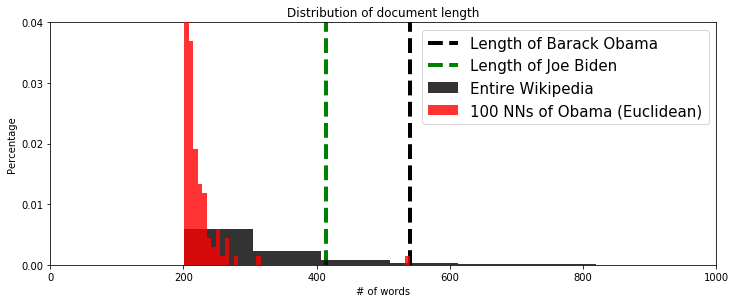

In [36]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True, label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbor_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True, label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].iloc[0], color='k', linestyle='--', linewidth=4, label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].iloc[0], color='g', linestyle='--', linewidth=4, label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

# Cosine Distance

In [37]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)

distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)

neighbors = pd.DataFrame({'distance':distances.flatten(), 'id':indices.flatten()})

nearest_neighbor_cosine = neighbors.merge(wiki, left_on='id', right_index=True)[['id', 'name', 'length', 'distance']]
nearest_neighbor_cosine.head(n=20)

,id,name,length,distance
0,35817,Barack Obama,540,0.000000
1,24478,Joe Biden,414,0.703139
2,38376,Samantha Power,310,0.742982
3,57108,Hillary Rodham Clinton,580,0.758358
4,38714,Eric Stern (politician),255,0.770561
5,46140,Robert Gibbs,257,0.784678
6,6796,Eric Holder,232,0.788039
7,44681,Jesse Lee (politician),216,0.790926
8,18827,Henry Waxman,279,0.798323
9,2412,Joe the Plumber,217,0.799466
